# Data Science Project

In this project, we will discover whatever it is possible to predict if anime will be successful in MyAnimeList.

This project's data was taken from the popular website MyAnimeList.
MyAnimeList is the world's largest database and social community for anime and manga. MyAnimeList includes lists of the "best" animes driven by the community-submitted scores. And we will try to find what influences those lists and makes anime successful with the help of machine learning algorithms. Successful anime I defined as an anime with a score of 7 and above.

My workflow will include five steps which are:
1. Defining a research question or hypothesis
2. Data acquisition
3. Data handling
4. EDA
5. Advanced data analysis

Now, the first step was already complete outside this notebook.
So let us go to the second step.

## 2. Data acquisition

some general imports, BeautifulSoup and requests which we will use for the crawler

In [1]:
import bs4
from bs4 import BeautifulSoup  
import pandas as pd
import numpy as np
import requests
import time
import random
import seaborn as sns
from matplotlib import pyplot as plt

A simple function to request a page and load the BeautifulSoup object

In [3]:
def load_soup_object(url):
    response = requests.get(url)
    return BeautifulSoup(response.content, 'html.parser')

Function to get the score on a page, used in ***extract_anime__info*** to get a score of prequel anime and the source score which is on different pages 

In [4]:
def get_score(url):
    soup=load_soup_object(url)
    try:
        return soup.find("span",itemprop="ratingValue").text.strip()
    except:
        return np.nan

The extract_anime__info function gets lists by reference with all the information gathered until now and adds the current anime information to the right lists. In case something was not found adds NaN.

In [6]:
def extract_anime__info(url,name,Type,score,members,have_prequal,prequal_score,is_original,source_score,studios,genres,synopsis,premiered):
    soup = load_soup_object(url)
    name.append(soup.find("h1",class_="title-name h1_bold_none").find("strong").text.strip())
    Type.append(soup.find("span",class_="dark_text",string="Type:").next_sibling.next_sibling.text.strip())
    try:
        score.append(soup.find("span",itemprop="ratingValue").text.strip())
    except:
         score.append(np.nan)
    members.append(soup.find("span",class_="numbers members").find("strong").text.strip())
    genres.append([genre.text for genre in soup.select('span[itemprop="genre"]')])
    synopsis.append(soup.find("p",itemprop="description").text.strip())
    try:
        premiered.append(soup.find("span",class_="dark_text",string="Premiered:").next_sibling.next_sibling.text.strip())
    except:
        premiered.append(np.nan)
    try:
        studios.append(soup.find("span",class_="information studio author").find("a").text.strip())
    except:
        studios.append(np.nan)
    if(soup.find("span",class_="dark_text",string="Source:").next_sibling.strip()!="Original"):
        is_original.append(0)
        try:
            source_url="https://myanimelist.net/"+soup.find("table",class_="anime_detail_related_anime").find("td",class_="ar fw-n borderClass",string="Adaptation:").next_sibling.find("a")["href"]
            time.sleep(2)
            source_score.append(get_score(source_url))
        except:
            source_score.append(np.nan)
    else:
        is_original.append(1)
        source_score.append(np.nan)
    try:
        temp=soup.find("table",class_="anime_detail_related_anime").find("td",class_="ar fw-n borderClass",string="Prequel:")
        if(temp!=None):
            have_prequal.append(1)
            prequel_url="https://myanimelist.net/"+temp.next_sibling.find("a")["href"]
            time.sleep(2)
            prequal_score.append(get_score(prequel_url))
        else:
            have_prequal.append(0)
            prequal_score.append(np.nan)
    except:
        have_prequal.append(0)
        prequal_score.append(np.nan)
 
    

Testing if extract_anime__info works well

In [36]:
start_time = time.time()
name=[]
Type=[]
score=[]
members=[]
have_prequal=[]
prequal_score=[]
is_original=[]
source_score=[]
studios=[]
genres=[]
synopsis=[]
premiered=[]
extract_anime__info("https://myanimelist.net/anime/34540/Pokemon_Movie_20__Kimi_ni_Kimeta",name,Type,score,members,have_prequal,prequal_score,is_original,source_score,studios,genres,synopsis,premiered)
print(prequal_score)
print("--- %s seconds ---" % (time.time() - start_time))

[nan]
--- 6.3908751010894775 seconds ---


And it works!
Now it is time to scrap the site.
The URL where the list is looks like https://myanimelist.net/topanime.php?limit= **pages**.
the **pages** are multiple of 50 cause every page has 50 anime on it.
So every time we finish scrapping the 50 animes on the page we add to the variable pages 50 and load the next page.
When we are on a new page we check the score of the anime at the head of the table, if it is a number we continue normally otherwise we set the pages variable to -1 and break the loop, returning a DataFrame from all the lists.

In [7]:
def crawler(url):
    name=[]
    Type=[]
    score=[]
    members=[]
    have_prequal=[]
    prequal_score=[]
    is_original=[]
    source_score=[]
    studios=[]
    genres=[]
    synopsis=[]
    premiered=[]
    for_errors=[name,Type,score,members,have_prequal,prequal_score,is_original,source_score,studios,genres,synopsis,premiered]
    pages=0
    soup=load_soup_object(url+str(pages))
    while(pages!=-1):
        if(soup.find("td",class_="score ac fs14").find("span").text=="N/A"):
            pages=-1
            continue
        pages+=50
        print(soup.find("td",class_="score ac fs14").find("span").text)
        links=soup.select('a[class="hoverinfo_trigger fl-l ml12 mr8"]')
        for link in links:
            time.sleep(5 + random.random())
            try:
                extract_anime__info(link["href"],name,Type,score,members,have_prequal,prequal_score
                                    ,is_original,source_score,studios,genres,synopsis,premiered)
            except:
                print(name[-1])
                _min=len(for_errors[0])
                for size in for_errors:
                    if(_min>len(size)):
                        _min=len(size)
                for x in for_errors:
                    if len(x)>_min:
                        x.pop()
        soup=load_soup_object(url+str(pages))
    return pd.DataFrame({'name':name,'score':score,'type':Type,'genres':genres,'members':members
                         ,'have_prequal':have_prequal,'prequal_score':prequal_score,'is_original':is_original
                         ,'source_score':source_score,'studio':studios,"premiered":premiered,"synopsis":synopsis})
        
        
        
        
    
    

In [8]:
start_time = time.time()
df=crawler("https://myanimelist.net/topanime.php?limit=")
print(df)
print("--- %s seconds ---" % (time.time() - start_time))

9.14
8.69
8.53
8.42
Yoru ni Kakeru
8.34
Gotcha!
Kawaki wo Ameku
Shelter (Music)
8.28
8.22
8.18
8.13
Interstella5555: The 5tory of The 5ecret 5tar 5ystem
8.10
8.05
8.01
Koukaku Kidoutai: Stand Alone Complex 2nd GIG - Individual Eleven
Koukaku Kidoutai: Stand Alone Complex 2nd GIG - Individual Eleven
Nagi no Asu kara
Nagi no Asu kara
Nagi no Asu kara
Nagi no Asu kara
Nagi no Asu kara
Nagi no Asu kara
Nagi no Asu kara
Nagi no Asu kara
Nagi no Asu kara
Nagi no Asu kara
Nagi no Asu kara
Nagi no Asu kara
Nagi no Asu kara
Marine Shukkou!!
7.97
7.94
7.91
Inochi no Tabekata
7.88
Dramaturgy
7.85
7.82
7.79
Ame wo Matsu,
The Everlasting Guilty Crown
7.77
Snow Halation
7.74
Ghost (Music)
Heikousen
7.72
Yuuseiboushi
7.70
7.68
Kokoro Yohou
7.66
7.64
7.62
Q
Ruru-chan no Jisatsu Haishin
7.60
Yoru wa Honoka
Raison d'être
7.58
7.56
Muteki-kyuu*Believer / Mirai Harmony
Uchiage Hanabi
Mekakucity Records
7.55
7.54
Tokyo Autumn Session
7.52
Hollowness
Mekakucity Days
Happy Party Train
Itte.
7.51
Bokura Mada 

6.09
Gravity (2019)
Hand in Hand
Bungaku Shoujo
Dive to Blue
Dr.
6.08
Sleeping Beauty
Quote
Showtime
Teeter
6.07
Kedamono Damono
Boku wa Kimi no Namida
Gin no Yuri
Girl Electric
Kimi dake no Boku de Iru kara
6.06
Misenai Namida wa, Kitto Itsuka
Mukougaoka Chisato wa Tada Mitsumeteita no Datta
Paradise (Music)
Towa no Kizuna
Timeless
6.05
Donten
Go Now!
Himawari
Jishu Seisaku Movie Binchou-tan
Lost
Piece
QUI
6.04
Hikari no Akuma
6.03
Neko Matsuri
Play the Lupin: Clips x Parts Collection
Urban Caravan
6.02
Witch Hat: Majo to Boushi no Waltz
Mine
Miss Monochrome: Watashi dake no Monogatari
Afraid To Be Cool / Raise Me Up
Fake Style
La Primavera
Aftermath
Bad Habits
6.00
By Your Side
Kotonoha Breakdown
Mahou Sensei Negima! Tokubetsu Eizou
Meryuu
Shina Dark: Kuroki Tsuki no Ou to Souheki no Tsuki no Himegimi
Still
Soratobu Toshi Keikaku
5.99
World's End Umbrella
Ao ga Niki Umi Yori Fukai Sora no Shita
Kaze wa Fuiteru ka?
Love in Ruins feat. Sinéad Harnett
Baymax
Dry Dry Try
5.98
Hitojichi K

Ai Uta: Since 2007
Akai Boushi
Beat in Love
Itsumademo Tabibito
Amaryllis
Bang Babang Bang!!!
Bouken no Susume
5.32
Ok? Alright!
Yamasuki, Yamazaki
Yanoya
Yubikiri
Outsider:Requiem
Uchuu no Uta
Youki ni Utaeba
Ake-Vono
Asa wo Kitan
5.30
Crescendo Story
It Seems like a Frog
Wamono
Wake Up
Bokura no Hero
Aishiteru (2010)
Hizumu Realism
Joki Joki Tailor
Koisuru Niwatori
5.28
Tic Tac Dreamin'
Zone: Intro
Frogtoise
Futago no Ookami Daibouken
Hoshi Uranai Kirakira
Irotoridori no Melody
Akaoni to Aooni no Tango
Attouteki Vivid Days
Happy Hour
Heya (Music)
Mirakururun Grand Purin!
Saboten ga Nikui
5.26
Mobile Dog House￥
Spicy Swingy Style
To Disappear
Toute wa Sono Kotae
Circles
Hello Again, JoJo
Koro wa Yane no Ue
Koto no Shidai
Donna Donna
Kumo ga Haretara
Marude Sekai
Moushin Soloist Life!
Qiezi Mabo Forever
Yuki no Hi no Tayori
5.23
Anger
Aoi Chou
Christmas Morgue
Kanashiki Mongoose
Tonight
5.21
Watashi no Kamifuusen (1983)
Eat You Up/Bunny
Gene
Hikaru Genji: Paradise Ginga
HuGoo.n no Hug 

Music type anime we didn't collect, we can see that as we start to scrap the lower score anime there was more music type anime. and after 35.5 hours! we finished and have all the data we need, now we will save the DataFrame as a CSV file

In [32]:
df.to_csv('malDB1.csv')

# 3. Data handling

In [2]:
df=pd.read_csv("malDB1.csv")

In [3]:
df.head()

,Unnamed: 0,name,score,type,genres,members,have_prequal,prequal_score,is_original,source_score,studio,premiered,synopsis
0,0,Fullmetal Alchemist: Brotherhood,9.14,TV,"['Action', 'Adventure', 'Drama', 'Fantasy', 'M...","2,893,173",0,NaN,0,9.06,Bones,Spring 2009,After a horrific alchemy experiment goes wrong...
1,1,Gintama°,9.08,TV,"['Action', 'Comedy', 'Sci-Fi', 'Gag Humor', 'H...","536,913",1,8.93,0,8.62,Bandai Namco Pictures,Spring 2015,"Gintoki, Shinpachi, and Kagura return as the f..."
2,2,Steins;Gate,9.08,TV,"['Drama', 'Sci-Fi', 'Suspense', 'Psychological...","2,245,142",0,NaN,0,8.04,White Fox,Spring 2011,Eccentric scientist Rintarou Okabe has a never...
3,3,Shingeki no Kyojin Season 3 Part 2,9.07,TV,"['Action', 'Drama', 'Gore', 'Military', 'Survi...","1,847,350",1,8.62,0,8.57,Wit Studio,Spring 2019,Seeking to restore humanity's diminishing hope...
4,4,Gintama',9.05,TV,"['Action', 'Comedy', 'Sci-Fi', 'Gag Humor', 'H...","473,330",1,8.95,0,8.62,Sunrise,Spring 2011,"After a one-year hiatus, Shinpachi Shimura ret..."


In [4]:
df.describe(include="all")

,Unnamed: 0,name,score,type,genres,members,have_prequal,prequal_score,is_original,source_score,studio,premiered,synopsis
count,11604.000000,11604,11602.000000,11604,11604,11604,11604.000000,2435.000000,11604.000000,2978.000000,9430,4139,11602
unique,NaN,11603,NaN,5,4188,8951,NaN,NaN,NaN,NaN,578,227,11231
top,NaN,Zuihou de Zhaohuan Shi,NaN,TV,['Comedy'],338,NaN,NaN,NaN,NaN,Toei Animation,Fall 2016,No synopsis information has been added to this...
freq,NaN,2,NaN,4165,396,11,NaN,NaN,NaN,NaN,656,69,200
mean,5801.500000,NaN,6.548440,NaN,NaN,NaN,0.212254,7.028197,0.272492,7.616921,NaN,NaN,NaN
std,3349.930596,NaN,0.906053,NaN,NaN,NaN,0.408922,0.811126,0.445261,0.621896,NaN,NaN,NaN
min,0.000000,NaN,1.850000,NaN,NaN,NaN,0.000000,3.130000,0.000000,5.390000,NaN,NaN,NaN
25%,2900.750000,NaN,5.970000,NaN,NaN,NaN,0.000000,6.510000,0.000000,7.170000,NaN,NaN,NaN
50%,5801.500000,NaN,6.560000,NaN,NaN,NaN,0.000000,7.090000,0.000000,7.600000,NaN,NaN,NaN
75%,8702.250000,NaN,7.200000,NaN,NaN,NaN,0.000000,7.580000,1.000000,8.080000,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11604 entries, 0 to 11603
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     11604 non-null  int64  
 1   name           11604 non-null  object 
 2   score          11602 non-null  float64
 3   type           11604 non-null  object 
 4   genres         11604 non-null  object 
 5   members        11604 non-null  object 
 6   have_prequal   11604 non-null  int64  
 7   prequal_score  2435 non-null   float64
 8   is_original    11604 non-null  int64  
 9   source_score   2978 non-null   float64
 10  studio         9430 non-null   object 
 11  premiered      4139 non-null   object 
 12  synopsis       11602 non-null  object 
dtypes: float64(3), int64(3), object(7)
memory usage: 1.2+ MB


Let's check the null value in our DataFrame.

In [6]:
df.isnull().sum()

Unnamed: 0          0
name                0
score               2
type                0
genres              0
members             0
have_prequal        0
prequal_score    9169
is_original         0
source_score     8626
studio           2174
premiered        7465
synopsis            2
dtype: int64

There are two animes without scores sneaked in, let's remove them.

In [7]:
df_clean=df.copy()
print(df_clean.shape)
df_clean.dropna(subset=["score"], inplace=True)
print(df_clean.shape)

(11604, 13)
(11602, 13)


Let's remove also the animes without a synopsis

In [8]:
print(df_clean.shape)
df_clean.dropna(subset=["synopsis"], inplace=True)
print(df_clean.shape)

(11602, 13)
(11600, 13)


I have decided to drop the "premiered" column as it's mostly empty and also the "Unnamed: 0" which I don't know what created it.

In [9]:
print(df_clean.shape)
df_clean.drop(columns=['Unnamed: 0','premiered'], inplace=True)
print(df_clean.shape)

(11600, 13)
(11600, 11)


let's check for duplicates.

In [10]:
df_clean[df_clean['name'].duplicated() == True]

,name,score,type,genres,members,have_prequal,prequal_score,is_original,source_score,studio,synopsis
5261,Zuihou de Zhaohuan Shi,6.67,ONA,"['Action', 'Adventure', 'Drama', 'Fantasy', 'H...","21,584",0,NaN,0,NaN,ASK Animation Studio,A talented young cook's encounter with a hungr...


We found one let's drop him.

In [11]:
print(df_clean.shape)
df_clean.drop_duplicates(subset=["name"], inplace=True)
print(df_clean.shape)

(11600, 11)
(11599, 11)


We can see there are 2462 animes without a prequel and from them, only 28 don't have a score so let's delete them.

In [12]:
df_clean["have_prequal"].value_counts()

0    9137
1    2462
Name: have_prequal, dtype: int64

In [13]:
df_clean.loc[df_clean["have_prequal"]==1,['prequal_score']].isna().sum()

prequal_score    28
dtype: int64

In [14]:
df_clean.iloc[561,6]

nan

In [15]:
to_del=df_clean.index[(df_clean["have_prequal"]==1 )& (df_clean["prequal_score"].isna())].tolist() #list with indexes to delete
print(df_clean.shape)
df_clean.drop(index=to_del,inplace=True)
df_clean.prequal_score.fillna(value=0,inplace=True)
print(df_clean.shape)

(11599, 11)
(11571, 11)


we deleted the unwanted animes and to the rest, we inserted 0 as a value.

In [16]:
df_clean.loc[df_clean["have_prequal"]==1,['prequal_score']].isna().sum()

prequal_score    0
dtype: int64

In [17]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11571 entries, 0 to 11601
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           11571 non-null  object 
 1   score          11571 non-null  float64
 2   type           11571 non-null  object 
 3   genres         11571 non-null  object 
 4   members        11571 non-null  object 
 5   have_prequal   11571 non-null  int64  
 6   prequal_score  11571 non-null  float64
 7   is_original    11571 non-null  int64  
 8   source_score   2978 non-null   float64
 9   studio         9408 non-null   object 
 10  synopsis       11571 non-null  object 
dtypes: float64(3), int64(2), object(6)
memory usage: 1.1+ MB


a problem I encounter is there are 8417 animes not original but only 2978 of them have a score for the source

In [18]:
df_clean["is_original"].value_counts()

0    8417
1    3154
Name: is_original, dtype: int64

In [19]:
df_clean.loc[df_clean["is_original"]==0,['source_score']]

,source_score
0,9.06
1,8.62
2,8.04
3,8.57
4,8.62
...,...
11587,NaN
11590,6.52
11591,NaN
11599,NaN


As we can see in the line plot the scores are on a slow downward trend and it looks like in the end there is a bunch of missing scores.

<AxesSubplot:>

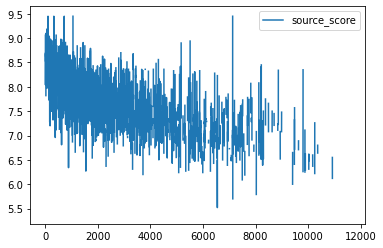

In [20]:
df_clean.loc[df_clean["is_original"]==0,['source_score']].plot()

In [21]:
df_clean.loc[df_clean["is_original"]==0,['source_score']].isna().sum()

source_score    5439
dtype: int64

I have decided to use the interpolate function to fill the missing scores,  interpolate allows me to keep the downward trend that we have seen in the line plot

In [22]:
df_clean.loc[df_clean["is_original"]==0,['source_score']]=df_clean.loc[df_clean["is_original"]==0,['source_score']].interpolate()

<AxesSubplot:>

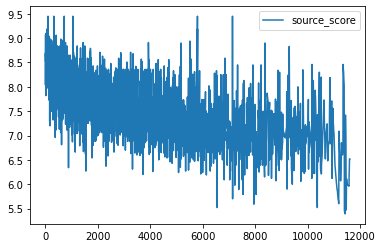

In [23]:
df_clean.loc[df_clean["is_original"]==0,['source_score']].plot()

looks good for me

In [24]:
df_clean.loc[df_clean["is_original"]==0,['source_score']].isna().sum()

source_score    0
dtype: int64

In [25]:
df_clean.source_score.isna().sum()

3154

The rest we fill with 0 as they don't have a source.

In [26]:
df_clean.source_score.fillna(value=0,inplace=True)

The missing studio we will fill with unknown.

In [27]:
df_clean.studio.fillna(value="unknown",inplace=True)

Now our DataFrame doesn't have missing value anymore.

In [28]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11571 entries, 0 to 11601
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           11571 non-null  object 
 1   score          11571 non-null  float64
 2   type           11571 non-null  object 
 3   genres         11571 non-null  object 
 4   members        11571 non-null  object 
 5   have_prequal   11571 non-null  int64  
 6   prequal_score  11571 non-null  float64
 7   is_original    11571 non-null  int64  
 8   source_score   11571 non-null  float64
 9   studio         11571 non-null  object 
 10  synopsis       11571 non-null  object 
dtypes: float64(3), int64(2), object(6)
memory usage: 1.1+ MB


we can see that the member column is an object type and not int let's fix it

In [29]:
print(df_clean['members'].dtype)
df_clean['members'] = df_clean.members.str.split(',').str.join('').astype(int)
print(df_clean['members'].dtype)

object
int32


In [30]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11571 entries, 0 to 11601
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           11571 non-null  object 
 1   score          11571 non-null  float64
 2   type           11571 non-null  object 
 3   genres         11571 non-null  object 
 4   members        11571 non-null  int32  
 5   have_prequal   11571 non-null  int64  
 6   prequal_score  11571 non-null  float64
 7   is_original    11571 non-null  int64  
 8   source_score   11571 non-null  float64
 9   studio         11571 non-null  object 
 10  synopsis       11571 non-null  object 
dtypes: float64(3), int32(1), int64(2), object(5)
memory usage: 1.0+ MB


apparently, pandas save list values as strings that's a problem we have to fix. I found a tutorial on how to fix it and it works well. [link](https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173)

In [31]:
type(df_clean["genres"][0])

str

In [32]:
df_clean["genres"] = df_clean["genres"].apply(eval)

In [33]:
type(df_clean["genres"][0])

list

In [34]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

In [35]:
unique_items = to_1D(df_clean["genres"]).value_counts()

In [36]:
print(unique_items)

Comedy               4663
Action               3514
Fantasy              2702
Adventure            2442
Sci-Fi               2226
                     ... 
Romantic Subtext       29
Crossdressing          27
Showbiz                22
Magical Sex Shift      20
Award Winning           5
Length: 74, dtype: int64


<AxesSubplot:ylabel='None'>

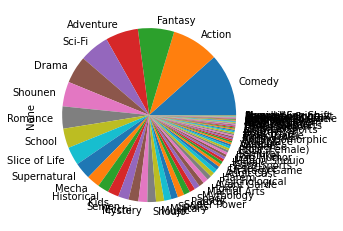

In [37]:
unique_items.plot(kind='pie')

let's find and delete the animes without genres.

In [38]:
to_del=[]
for i,_list in enumerate(df_clean["genres"]):
    if (_list==[]):
        to_del.append(i)

    

In [39]:
print(df_clean.shape)
df_clean.drop(index=to_del,inplace=True)
df_clean.reset_index(drop=True,inplace=True)
print(df_clean.shape)

(11571, 11)
(11534, 11)


# 3. EDA

let's check the correlation between the source score and the score, the prequel score, and the score and the source score prequel score.

<AxesSubplot:>

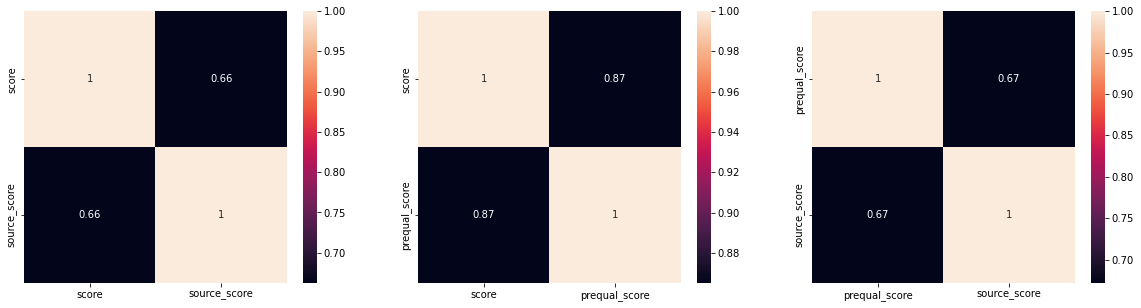

In [40]:
corr1=df_clean[df_clean["source_score"]!=0][["score","source_score"]].corr()
corr2=df_clean[df_clean["prequal_score"]!=0][["score","prequal_score"]].corr()
corr3=df_clean[(df_clean["prequal_score"]!=0)&(df_clean["source_score"]!=0)][["prequal_score","source_score"]].corr()
fig, ax = plt.subplots(1, 3,figsize=(20,5))
sns.heatmap(corr1, annot=True, ax=ax[0])
sns.heatmap(corr2, annot=True, ax=ax[1])
sns.heatmap(corr3, annot=True, ax=ax[2])

we can see there is a strong correlation between the prequel score and the score (0.87).


in this pie chart, we can see the Distribution of different anime types, and we can see there are as many as 2-3 times more tv shows than the rest of the types.

TV         4141
Movie      2262
Special    1878
OVA        1789
ONA        1464
Name: type, dtype: int64


<AxesSubplot:ylabel='type'>

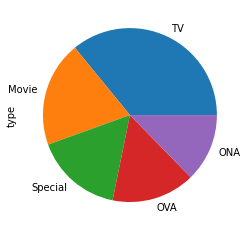

In [41]:
print(df_clean.type.value_counts())
df_clean.type.value_counts().plot(kind='pie')

I have decided to check also the mean values for each anime type of source vs regular score and prequel vs regular score.

<AxesSubplot:xlabel='type'>

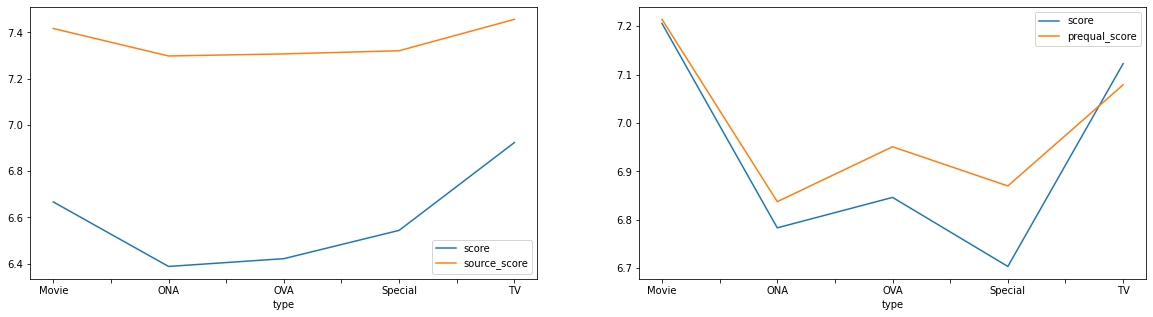

In [42]:
fig, ax = plt.subplots(1, 2,figsize=(20,5))
df_clean[df_clean["source_score"]!=0].groupby("type").mean()[["score","source_score"]].plot(kind="line",ax=ax[0] )
df_clean[df_clean["prequal_score"]!=0].groupby("type").mean()[["score","prequal_score"]].plot(kind="line",ax=ax[1])


we can see that the source mean score is higher on all types, and the prequel mean score is very similar to the regular score which was expected as they have a very strong correlation.

now let's check the means score between original anime to non-original

<AxesSubplot:xlabel='type'>

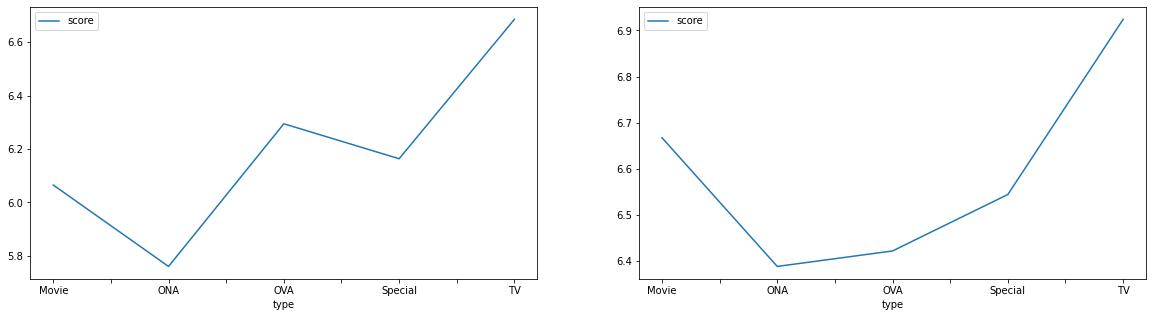

In [45]:
fig, ax = plt.subplots(1, 2,figsize=(20,5))
df_clean[df_clean["is_original"]==1].groupby("type").mean()[["score"]].plot(kind="line",ax=ax[0] )
df_clean[df_clean["is_original"]==0].groupby("type").mean()[["score"]].plot(kind="line",ax=ax[1])

we can see that the non-original has a higher score in all types also we can see that the ONA type has the lowest mean score in both and TV has the highest.

and lastly, let's check a scatter plot for the number of members against the score.

<AxesSubplot:xlabel='[score]', ylabel='[members]'>

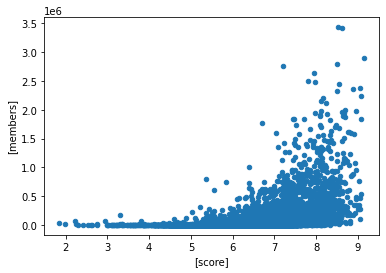

In [46]:
df_clean.plot.scatter(x=['score'],y=['members'])

we can see that more members mean higher score

now let's add the is_successful column, 1 means that the anime score is 7 or higher and 0 is less than 7.

In [47]:
df_clean["is_successful"]=np.where(df_clean["score"] >=7, 1, 0)

In [48]:
df_clean["is_successful"].value_counts()

0    7693
1    3841
Name: is_successful, dtype: int64

now let's encode the categorical values. for the genres column, I used MultiLabelBinarizer to encode which creat a one-hot matrix. I couldn't use the OneHotEncoder because the genres column had a list as a value, for the type and studio column I used LabelEncoder 

In [49]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
mlb=MultiLabelBinarizer()
final_df=df_clean.copy()
temp = mlb.fit_transform(final_df['genres'])
final_df= final_df.join(pd.DataFrame(temp, columns=mlb.classes_))
final_df["type"]=LabelEncoder().fit_transform(final_df["type"])
final_df["studio"]=LabelEncoder().fit_transform(final_df["studio"])
final_df.drop(columns=['genres'],inplace=True)
final_df.head()

,name,score,type,members,have_prequal,prequal_score,is_original,source_score,studio,synopsis,...,Super Power,Supernatural,Survival,Suspense,Team Sports,Time Travel,Vampire,Video Game,Visual Arts,Workplace
0,Fullmetal Alchemist: Brotherhood,9.14,4,2893173,0,0.00,0,9.06,73,After a horrific alchemy experiment goes wrong...,...,0,0,0,0,0,0,0,0,0,0
1,Gintama°,9.08,4,536913,1,8.93,0,8.62,61,"Gintoki, Shinpachi, and Kagura return as the f...",...,0,0,0,0,0,0,0,0,0,0
2,Steins;Gate,9.08,4,2245142,0,0.00,0,8.04,539,Eccentric scientist Rintarou Okabe has a never...,...,0,0,0,1,0,1,0,0,0,0
3,Shingeki no Kyojin Season 3 Part 2,9.07,4,1847350,1,8.62,0,8.57,540,Seeking to restore humanity's diminishing hope...,...,0,0,1,0,0,0,0,0,0,0
4,Gintama',9.05,4,473330,1,8.95,0,8.62,472,"After a one-year hiatus, Shinpachi Shimura ret...",...,0,0,0,0,0,0,0,0,0,0


let's create a word cloud for the successful anime's synopsis and a word cloud for the non-successful anime's synopsis and see if there is a difference visible to the eye.

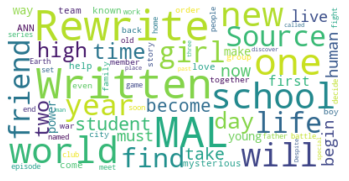

In [48]:
from wordcloud import WordCloud
text = " ".join(review for review in final_df[final_df["is_successful"]==1]["synopsis"])
wordcloud = WordCloud(max_font_size=50, max_words=75, background_color="white",collocations=False).generate_from_text(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

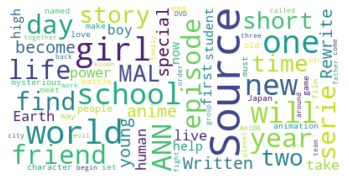

In [49]:
text = " ".join(review for review in final_df[final_df["is_successful"]==0]["synopsis"])
wordcloud = WordCloud(max_font_size=50, max_words=75, background_color="white",collocations=False).generate_from_text(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

and they are very much similar and I don't see a real difference.

# 5. Advanced data analysis

in this part, I understood that I have a big problem cause part of the data is text (the synopsis) which needs different handling than my numerical values. after a few hours, I found the concept of Hybrid Machine Learning Models and the package [mlxtend](http://rasbt.github.io/mlxtend/) ([in this video](https://www.youtube.com/watch?v=E2_IhBKxBxM&list=WL&index=2)). mlxtend offers a classifier that takes multiple models' answers and combines them into one by "voting". so I will build a model for the text and a model for the rest and combine them. ![image](http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier_files/majority_voting.png)

let's split the data to train and test and drop the unnecessary columns

In [50]:
from sklearn.model_selection import train_test_split
X=final_df.drop(columns=["name","score","is_successful"])
y=final_df.is_successful
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

###  1. the text model

I started with tying the Naive Bayes classifier 

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix,classification_report, accuracy_score
text_clf_nb = Pipeline([
    ('vect', CountVectorizer(stop_words="english",min_df=5,max_features=500)),
    ('norm', preprocessing.Normalizer(norm='l1')),
    ('clf', MultinomialNB()),
])

0.6623320329432163


C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


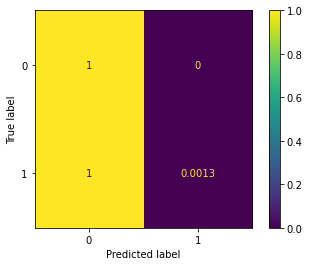

In [52]:
text_clf_nb.fit(X_train.synopsis,y_train)
pred=text_clf_nb.predict(X_test.synopsis)
print(accuracy_score(y_test,pred))
plot_confusion_matrix(text_clf_nb,X_test.synopsis,y_test, normalize = "true")

In [53]:
from sklearn import metrics
print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.66      1.00      0.80      1527
           1       1.00      0.00      0.00       780

    accuracy                           0.66      2307
   macro avg       0.83      0.50      0.40      2307
weighted avg       0.78      0.66      0.53      2307



66% but it looks like he doesn't work well on our data.


let's try now the SVM classifier.

0.7459904638058084


C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


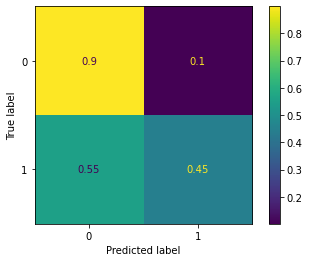

In [54]:
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([
    ('vect', CountVectorizer(stop_words="english",min_df=5,max_features=500,analyzer='word')),
    ('norm', preprocessing.Normalizer(norm='l1')),
    ('clf', SGDClassifier(loss="hinge")),
])

text_clf_svm.fit(X_train.synopsis,y_train)

predicted = text_clf_svm.predict(X_test.synopsis)
print(accuracy_score(y_test,predicted))
plot_confusion_matrix(text_clf_svm,X_test.synopsis,y_test, normalize = "true")

and he works much better at 74% and his result makes more sense.

In [55]:
from sklearn.model_selection import cross_val_score
cross_val_score(text_clf_svm,X_train.synopsis,y_train,cv=10,scoring='accuracy').mean()

0.7479134107162582

let's find what is the best parameters for our model

In [56]:
params={}
params['vect__min_df']=[1,2,3,4,5]
params['vect__max_features']=[100,500,1000,2000,3000,4000]
params['clf__penalty']=['l1','l2','elasticnet']
params['clf__average']=[True, False]

In [57]:
from sklearn.model_selection import GridSearchCV

grid =GridSearchCV(text_clf_svm,params,cv=5,scoring='accuracy',n_jobs=-1)
grid.fit(X_train.synopsis,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(max_features=500,
                                                        min_df=5,
                                                        stop_words='english')),
                                       ('norm', Normalizer(norm='l1')),
                                       ('clf', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'clf__average': [True, False],
                         'clf__penalty': ['l1', 'l2', 'elasticnet'],
                         'vect__max_features': [100, 500, 1000, 2000, 3000,
                                                4000],
                         'vect__min_df': [1, 2, 3, 4, 5]},
             scoring='accuracy')

In [58]:
grid.best_score_

0.7522487352717515

In [59]:
grid.best_params_

{'clf__average': False,
 'clf__penalty': 'l1',
 'vect__max_features': 1000,
 'vect__min_df': 3}

now that we found the best parameters let's create the final text model

Accuracy on training data =  0.7522488349409342
Accuracy on test data =  0.7524924143909839


C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


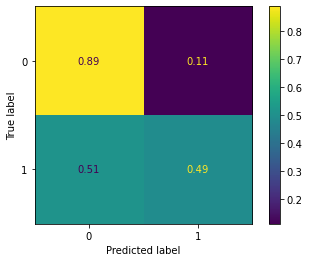

In [60]:
final_text_clf_svm = Pipeline([
    ('vect', CountVectorizer(stop_words="english",min_df=3,max_features=1000,analyzer='word')),
    ('norm', preprocessing.Normalizer(norm='l1')),
    ('clf', SGDClassifier(loss="hinge",average=False,penalty='l1')),
])

final_text_clf_svm.fit(X_train.synopsis,y_train)

predicted = final_text_clf_svm.predict(X_train.synopsis)
print('Accuracy on training data = ', 
      accuracy_score(y_train, predicted))
predicted = final_text_clf_svm.predict(X_test.synopsis)
print('Accuracy on test data = ', 
      accuracy_score(y_test,predicted ))
plot_confusion_matrix(final_text_clf_svm,X_test.synopsis,y_test, normalize = "true")

In [61]:
cross_val_score(final_text_clf_svm,X_train.synopsis,y_train,cv=10,scoring='accuracy').mean()

0.7517066859693117

and we have a model with 75 percent accuracy which is not bad!

### 2. the numerical model

let's move to the numerical model. I found online a trick for the GridSearchCV so in one run he will give results for a couple of classifiers through one Pipeline, so let's use it.


In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

clf1=RandomForestClassifier()
clf2=KNeighborsClassifier()

In [77]:
numerical_clf = Pipeline([('clf', clf1),])

In [78]:
params1={}
params1['clf__max_depth']=[3,4,5,6,7,8,9,10]
params1['clf__max_features']=['sqrt', 'log2']
params1['clf__n_estimators']=[100,200,300,400,500]
params1['clf__class_weight']=[None,'balanced']
params1['clf']=[clf1]

In [79]:
params2={}
params2['clf__n_neighbors']=[2,3,4,5,6,7,8,9,10]
params2['clf']=[clf2]

In [80]:
clf_params=[params1,params2]

In [81]:
grid =GridSearchCV(numerical_clf,clf_params,cv=5,scoring='accuracy',n_jobs=-1)
grid.fit(X_train.drop(columns=["synopsis"]),y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('clf',
                                        RandomForestClassifier(max_depth=10,
                                                               n_estimators=400))]),
             n_jobs=-1,
             param_grid=[{'clf': [RandomForestClassifier(max_depth=10,
                                                         n_estimators=400)],
                          'clf__class_weight': [None, 'balanced'],
                          'clf__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                          'clf__max_features': ['sqrt', 'log2'],
                          'clf__n_estimators': [100, 200, 300, 400, 500]},
                         {'clf': [KNeighborsClassifier()],
                          'clf__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10]}],
             scoring='accuracy')

In [82]:
grid.best_score_

0.8630117414933629

In [83]:
grid.best_params_

{'clf': RandomForestClassifier(max_depth=10, n_estimators=400),
 'clf__class_weight': None,
 'clf__max_depth': 10,
 'clf__max_features': 'sqrt',
 'clf__n_estimators': 400}

with the parameters, we found let's final model for the numerical values


Accuracy on training data =  0.890647014197464
Accuracy on test data =  0.8625921109666234


C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


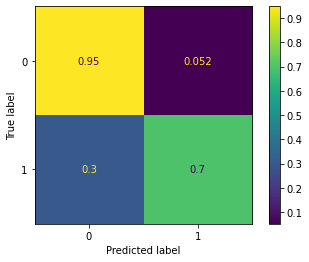

In [84]:
final_numerical_clf = Pipeline([
    ('clf', RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=400,class_weight = None)),
])

final_numerical_clf.fit(X_train.drop(columns=["synopsis"]),y_train)

predicted = final_numerical_clf.predict(X_train.drop(columns=["synopsis"]))
print('Accuracy on training data = ', 
      accuracy_score(y_train, predicted))
predicted = final_numerical_clf.predict(X_test.drop(columns=["synopsis"]))
print('Accuracy on test data = ', 
      accuracy_score(y_test,predicted ))
plot_confusion_matrix(final_numerical_clf,X_test.drop(columns=["synopsis"]),y_test, normalize = "true")

In [85]:
cross_val_score(final_numerical_clf,X_train.drop(columns=["synopsis"]),y_train,cv=10,scoring='accuracy').mean()

0.8596518708446238

and we got a model with 86% accuracy which is really good, in the bar plot below we can see what features influence the model the most

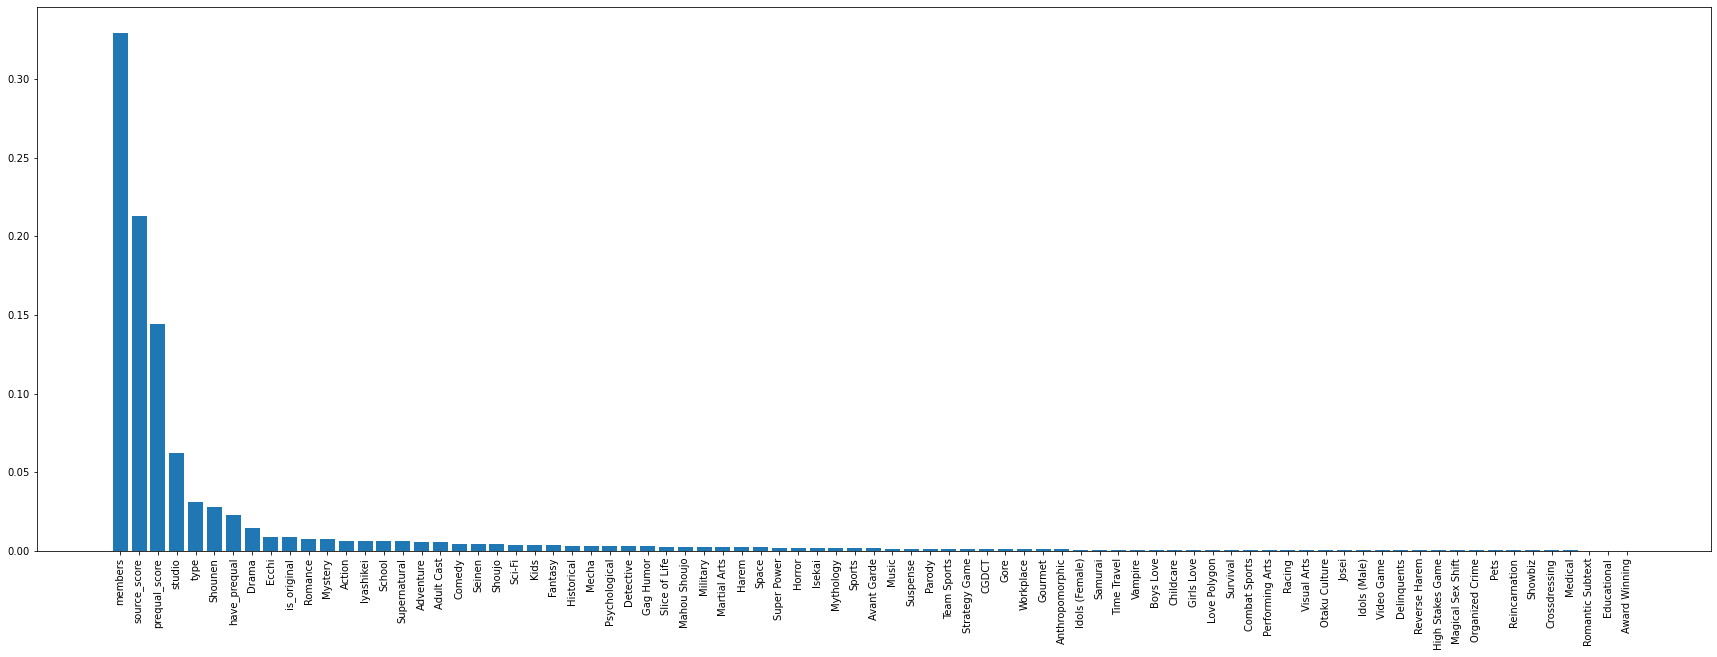

In [103]:
importances = pd.DataFrame(data={'Attribute': X_train.drop(columns=["synopsis"]).columns,'Importance': final_numerical_clf['clf'].feature_importances_})
importances = importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(30,10))
plt.bar(x=importances['Attribute'], height=importances['Importance'])
plt.xticks(rotation='vertical')
plt.show()

### 3. vote model

because each model uses different columns we will use ColumnSelector in a new Pipeline and give each model the right columns

In [104]:
from mlxtend.feature_selection import ColumnSelector
pipe1 = Pipeline([('columnselect',ColumnSelector(cols=("synopsis"),drop_axis=True)),('clf',final_text_clf_svm)])
mycols=[x for x in X if x!='synopsis']
pipe2= Pipeline([('columnselect',ColumnSelector(cols=(mycols),drop_axis=True)),('clf',final_numerical_clf)])


because probability estimates are not available for loss='hinge we will use  CalibratedClassifierCV to calibrate the classifier

In [105]:
from sklearn.calibration import CalibratedClassifierCV
clf=pipe1.fit(X_train,y_train)
calibrator = CalibratedClassifierCV(clf,cv='prefit')
model=calibrator.fit(X_train, y_train)


C:\Users\User\anaconda3\lib\site-packages\mlxtend\classifier\ensemble_vote.py:173: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.8136107498916342


C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


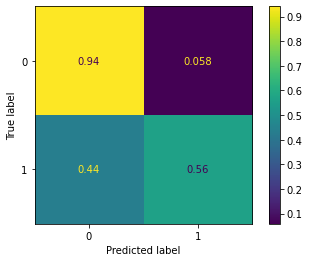

In [106]:
from mlxtend.classifier import EnsembleVoteClassifier
model_clfs = EnsembleVoteClassifier(
    clfs = [model,pipe2],
    voting = "soft",
    weights = [1,1],
    fit_base_estimators = False
).fit(X_train, y_train)

pred_clfs = model_clfs.predict(X_test)

print(accuracy_score(y_test, pred_clfs))
plot_confusion_matrix(model_clfs, X_test, y_test, normalize = "true")

and... we got a worse model with only 81% accuracy even after trying different parameters the best we get is the accuracy of the numerical model which means that the voting classifier just ignores the text model.

***In conclusion***, I think we successfully answered the question of whether it's possible to predict if anime will be successful in MyAnimeList with up to 86% success if we just use the numerical classifier
